<center><b><font size="5">Deeply virtual Compton scattering beyond next-to-leading order: the flavor singlet case</font></b></center><br>
This is the jupyter/python code that reproduces some figures from paper by K. Kumericki, D. Mueller, K. Passek-Kumericki and
A. Schafer <i>Deeply virtual Compton scattering beyond next-to-leading order: the flavor singlet case</i>, published in Physics Letters <b>B648</b> 186-194 (2007) [arXiv:<a href='https://arxiv.org/abs/hep-ph/0605237'>hep-ph/0605237</a>].

Figures for the published paper were produced by older Fortan version of the same code.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import gepard as g
print(g.__version__)

0.9.9


In [3]:
def ansatz06(j: np.ndarray, t: float, type: str) -> np.ndarray:
    """GPD ansatz from hep-ph/0605237."""
    par = {}
    par['al0s'] = 1.1
    par['alps'] = 0.25
    par['alpg'] = 0.25
    pochs = 8
    pochg = 6
    if type == 'hard':
        par['ng'] = 0.4
        par['al0g'] = par['al0s'] + 0.1
    elif type == 'soft':
        par['ng'] = 0.3
        par['al0g'] = par['al0s']
    par['ns'] = 2/3 - par['ng']
    singlet = g.gpd.qj(j, t, pochs, par['ns'], par['al0s'], 
                      alpf=0, alp=par['alps']) 
    gluon = g.gpd.qj(j, t, pochg, par['ng'], par['al0g'],
                    alpf=0, alp=par['alpg']) 
    return np.array((singlet, gluon, np.zeros_like(gluon), np.zeros_like(gluon)))

In [4]:
class MyTheory(g.ConformalSpaceGPD, g.MellinBarnesCFF):
    """Model from hep-ph/0605237."""
    
    def __init__(self, type, **kwargs) -> None:
        # defaults from old Fortran's GEPARD.INI
        kwargs.setdefault('p', 1)
        kwargs.setdefault('scheme', 'csbar')
        kwargs.setdefault('nf', 3)
        kwargs.setdefault('Q02', 1.0)
        kwargs.setdefault('asp', np.array([0.05, 0.05, 0.05]))
        kwargs.setdefault('phi', np.pi/2)
        self.type = type
        super().__init__(**kwargs)

    def H(self, eta: float, t: float) -> np.ndarray:
        return ansatz06(self.jpoints, t, self.type).transpose()


# Figure 1

In [5]:
models = {}
for p in [0, 1]:
    for scheme in ['csbar', 'msbar']:
        for type in ['hard', 'soft']:
            models[(p, scheme, type)] = MyTheory(type, p=p, scheme=scheme, Q02=2.5)

In [6]:
def Kfactor(xi, t, scheme, type):
    pt = g.DataPoint({'xi': xi, 'Q2': 2.5, 't': t})
    Habs = {}
    for p in [0, 1]:
        m = models[(p, scheme, type)]
        Habs[p] = np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2)
    return np.log(Habs[1])/np.log(Habs[0])

In [7]:
xis = [1e-5, 0.05]
Ks = {}
for scheme in ['csbar', 'msbar']:
    for type in ['hard', 'soft']:
        for xi in xis:
            print(f'{scheme}, {type}, {xi} -> {Kfactor(xi, 0, scheme, type):.7}')

csbar, hard, 1e-05 -> 0.938648
csbar, hard, 0.05 -> 0.9098002
csbar, soft, 1e-05 -> 0.9867925
csbar, soft, 0.05 -> 0.9549633
msbar, hard, 1e-05 -> 0.9056993
msbar, hard, 0.05 -> 0.8622445
msbar, soft, 1e-05 -> 0.978448
msbar, soft, 0.05 -> 0.9253767


In [8]:
## Numbers by radcorr.f (which was used to produce the Fig. 1):
# 0.9386480
# 0.9098002
# 0.9867925
# 0.9549633
# 0.9056993
# 0.8622445
# 0.9784480
# 0.9253767

So this agrees perfectly. We now plot the Fig 1a. Lines are slightly different from published fig. One of the reason for MSBAR diffference is that at the time of producing the paper we had only diagonal part of MSBAR formalism. There are also slight discrepancies with CSBAR lines, not large enought to force us to investigate. In the light of all this, figure below should be taken as improvement on the figure in the published paper.

In [9]:
xis = np.logspace(-5, -1.6)

In [10]:
Ks = {}
for scheme in ['csbar', 'msbar']:
    for type in ['hard', 'soft']:
        Ks[(scheme, type)] = []
        for xi in xis:
            Ks[(scheme, type)].append(Kfactor(xi, 0, scheme, type))

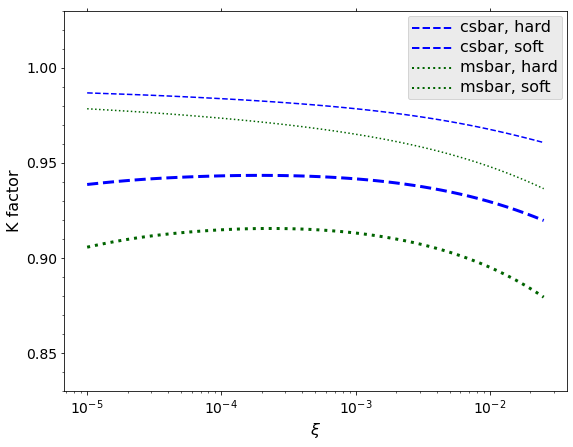

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9,7))
lstyle = {('csbar', 'hard') : (3, 'blue', '--'),
          ('csbar', 'soft') : (1.5, 'blue', '--'),
          ('msbar', 'hard') : (3, 'darkgreen', ':'),
          ('msbar', 'soft') : (1.5, 'darkgreen', ':')}
for scheme in ['csbar', 'msbar']:
    for type in ['hard', 'soft']:
        width, color, style = lstyle[(scheme, type)]
        ax.plot(xis, Ks[(scheme, type)],
                lw=width, ls=style, color=color, label=f'{scheme}, {type}')
ax.set_xscale('log')
ax.set_xlabel(r'$\xi$', fontsize=16)
ax.set_ylabel(r'K factor', fontsize=16)
ax.set_ylim(0.83, 1.03)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.01))
ax.tick_params(axis='both', which='major', labelsize=14, top=True)
leg = ax.legend(handlelength=4, fancybox=True)
frame  = leg.get_frame()                                                          
frame.set_facecolor('0.90')     
for t in leg.get_texts():                                                         
    t.set_fontsize(16)                             
for l in leg.get_lines():                                                         
    l.set_linewidth(2.0) 
fig.canvas.draw()

# Figure 2

In [12]:
models = {}
for p in [0, 1]:
    for scheme in ['csbar']:
        for type in ['hard', 'soft']:
            models[(p, scheme, type)] = MyTheory(type, p=p, scheme=scheme, q02=1.0)

In [13]:
def lnabsh(m, xi, t, Q2):
    pt = g.DataPoint({'xi': xi, 'Q2': Q2, 't': t})
    return np.log(np.sqrt(m.ReH(pt)**2 + m.ImH(pt)**2))

In [14]:
def Kdotfactor(xi, t, scheme, type):
    pt = g.data.DataPoint({'xi': xi, 'Q2': 4.0, 't': t})
    derh = {}
    for p in [0, 1]:
        m = models[(p, scheme, type)]
        derh[p] = g.quadrature.deriv(lambda Q2: lnabsh(m, xi, t, Q2),
                                  pt.Q2, 0.41, 12)
    # print(f'errs = {derh[1][1]}, {derh[0][1]}')
    return derh[1][0]/derh[0][0]

In [15]:
xis = [1e-5, 0.05]
Kdots = {}
for scheme in ['csbar']:
    for type in ['hard', 'soft']:
        for t in [0, -0.5]:
            for xi in xis:
                print(f'{scheme}, {type}, t={t}, xi={xi} -> {Kdotfactor(xi, t, scheme, type):.7}')

csbar, hard, t=0, xi=1e-05 -> 1.809114
csbar, hard, t=0, xi=0.05 -> 2.661404
csbar, hard, t=-0.5, xi=1e-05 -> 1.621904
csbar, hard, t=-0.5, xi=0.05 -> 2.612975
csbar, soft, t=0, xi=1e-05 -> 1.252116
csbar, soft, t=0, xi=0.05 -> 3.069379
csbar, soft, t=-0.5, xi=1e-05 -> 1.206956
csbar, soft, t=-0.5, xi=0.05 -> 2.876556


In [16]:
## Numbers by scaledep.f (which was used to produce the Fig. 1):
# 1.8091135
# 2.6614041
# 1.6273480
# 2.5720850
# 1.2521165
# 3.0693790
# 1.2056405
# 2.7173541

In [17]:
xis = np.logspace(-5, -1.6)

In [18]:
Kdots = {}
for scheme in ['csbar']:
    for type in ['hard', 'soft']:
        for t in [0, -0.5]:
            Kdots[(scheme, type, t)] = []
            for xi in xis:
                Kdots[(scheme, type, t)].append(Kdotfactor(xi, t, scheme, type))

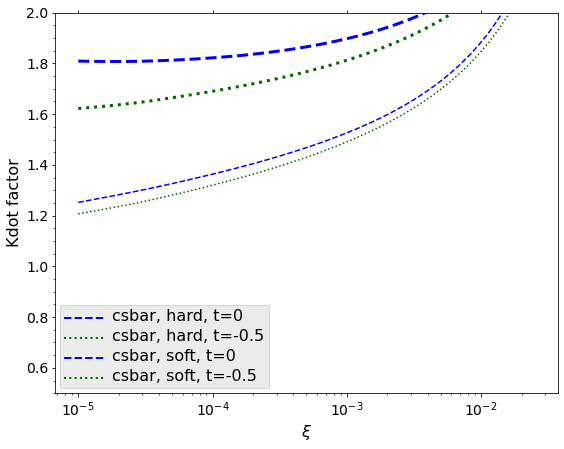

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9,7))
lstyle = {('csbar', 'hard', 0) : (3, 'blue', '--'),
          ('csbar', 'soft', 0) : (1.5, 'blue', '--'),
          ('csbar', 'hard', -0.5) : (3, 'darkgreen', ':'),
          ('csbar', 'soft', -0.5) : (1.5, 'darkgreen', ':')
         }
for scheme in ['csbar']:
    for type in ['hard', 'soft']:
        for t in [0, -0.5]:
            width, color, style = lstyle[(scheme, type, t)]
            ax.plot(xis, Kdots[(scheme, type, t)],
                    lw=width, ls=style, color=color,
                    label=f'{scheme}, {type}, t={t}')
ax.set_xscale('log')
ax.set_xlabel(r'$\xi$', fontsize=16)
ax.set_ylabel(r'Kdot factor', fontsize=16)
ax.set_ylim(0.5, 2)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.05))
ax.tick_params(axis='both', which='major', labelsize=14, top=True)
leg = ax.legend(handlelength=4, fancybox=True)
frame  = leg.get_frame()                                                          
frame.set_facecolor('0.90')     
for t in leg.get_texts():                                                         
    t.set_fontsize(16)                             
for l in leg.get_lines():                                                         
    l.set_linewidth(2.0) 
fig.canvas.draw()

Published paper has also NNLO curves, but Python gepard have only
NLO implemented at the moment.